In [1]:
%run 'ks25_Read_epistasis.ipynb'
notebook_prefix = 'ks26'
image_counter = Counter()

/Users/karen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/karen/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)



Reading precalculated epistasis...
/Users/karen/HIS3InterspeciesEpistasis/Analysis/Karen/files_dump/epistasis_in_foursomes/



Variable "ep_dict" is a dictionary. 
Keys are tuples (mutA, mutB) and values are pandas.Series of epistasis between mutA and mutB in all backgrounds.

Function get_ep_summary takes ep_dict as an argumant and applies an arbitrary function to every pd.Series object.

natlib_filtering is currently True. This can be changed in the cell #2.



In [57]:
import scipy
from scipy import stats

### Reading epistasis data

In [83]:
def get_ep_summary(epistasis_dictionary, function):
    floatprogress = FloatProgress(min=0, max=len(epistasis_dictionary))
    display(floatprogress)
    summary_dict = OrderedDict()
    for k,v in epistasis_dictionary.items():
        summary_dict[k] = function(v)
        floatprogress.value += 1
    return summary_dict

In [213]:
def get_fraction_strong(ep_series, strong_epistasis_threshold=0.4):
    strong = ep_series[np.abs(ep_series) > strong_epistasis_threshold]
    return 1. * len(strong) / len(ep_series)

In [215]:
ep_summary_mean = get_ep_summary(ep_dict, np.mean)
ep_summary_median = get_ep_summary(ep_dict, np.median)
ep_summary_std = get_ep_summary(ep_dict, np.std)
ep_summary_skew = get_ep_summary(ep_dict, scipy.stats.skew)

ep_summary_fraction_04 = get_ep_summary(ep_dict, lambda series: get_fraction_strong(series, strong_epistasis_threshold=0.4))
ep_summary_fraction_05 = get_ep_summary(ep_dict, lambda series: get_fraction_strong(series, strong_epistasis_threshold=0.5))

In [220]:
ep_summary = pd.DataFrame.from_items([('epistasis_mean', ep_summary_mean), 
                                      ('epistasis_median', ep_summary_median),
                                     ('epistasis_std', ep_summary_std),
                                     ('epistasis_skew', ep_summary_skew),
                                     ('ep_strong_fraction_04' ,ep_summary_fraction_04),
                                     ('ep_strong_fraction_05' ,ep_summary_fraction_05)])

ep_summary.reset_index(inplace=True)
ep_summary.rename(columns={'level_0':'mutA', 'level_1':'mutB'}, inplace=True)
ep_summary[:2]

,mutA,mutB,epistasis_mean,epistasis_median,epistasis_std,epistasis_skew,ep_strong_fraction_04,ep_strong_fraction_05
0,102K,104L,-0.076168,0.0,0.232586,-0.868850,0.091075,0.066734
1,102K,105H,-0.022907,0.0,0.206599,-1.022725,0.047122,0.038239


### Reading structural information

In [94]:
%run 'ks27_Read_structural_information.ipynb'


Variables: 
- structural_data:		pandas.DataFrame with some structural information,
- get_distance_24mer:		function for getting distances between two positions
				(this also works: get_distance_24mer(13, 'substrate'))
- quantitative_columns_dict:	nice names for some columns in structural_data,
- his3_24mer_file:		path to predicted His3 24mer structure.



In [112]:
%run 'ks20_Read_ddG.ipynb'


Variables: 
- predicted_ddG:		Pandas DataFrame with all calculated ddG (single, double and triple mutants (?)),
- predicted_doubles:		doubles only (Pandas DataFrame),
- predicted_singles:		singles only (Pandas DataFrame),
- get_ddG:			function that returns predicted ddG for a genotype
- by_position_mean_ddG:		mean ddG value at each position,
- by_position_var_ddG:		variance of predicted ddG at each position.



In [136]:
%run 'ks21_Read_impacts_of_mutations.ipynb'

Fitness impacts in the form "mutation" : "impacts in all backgrounds" is available as fit_dict

Variables: 

- fit_dict: a dictionary, keys are mutations and values are pandas.Series of fitness impacts in all backgrounds. 



### Merging structural information with epistasis data

In [221]:
position_to_segment = {}
for segment in positions.segment:
    for position in positions.set_index('segment').loc[segment]['positions_Uniprot_P06633']:
        position_to_segment[position] = segment

In [247]:
ep_summary['positionA'] = ep_summary['mutA'].apply(lambda s: int(s[:-1]))
ep_summary['positionB'] = ep_summary['mutB'].apply(lambda s: int(s[:-1]))


ep_summary['segment'] = ep_summary['positionA'].apply(lambda p: position_to_segment[p]) #checking only one position

ep_summary['distance_24mer'] = ep_summary.apply(lambda df: get_distance_24mer(df['positionA'], df['positionB']), axis=1)

ep_summary['ddG_A'] = ep_summary['mutA'].apply(get_ddG)
ep_summary['ddG_B'] = ep_summary['mutB'].apply(get_ddG)
ep_summary['ddG_double'] = ep_summary.apply(lambda df: get_ddG(df['mutA'] + ':' + df['mutB']), axis=1)

ep_summary['mean_fit_impact_A'] = ep_summary['mutA'].apply(lambda m: get_fitness_impact(fit_dict, m, np.mean))
ep_summary['mean_fit_impact_B'] = ep_summary['mutB'].apply(lambda m: get_fitness_impact(fit_dict, m, np.mean))
ep_summary['std_fit_impact_A'] = ep_summary['mutA'].apply(lambda m: get_fitness_impact(fit_dict, m, np.std))
ep_summary['std_fit_impact_B'] = ep_summary['mutB'].apply(lambda m: get_fitness_impact(fit_dict, m, np.std))
ep_summary['mean_fit_impact_A+B'] = ep_summary.apply(lambda df: df['mean_fit_impact_A']+df['mean_fit_impact_B'], axis=1)

ep_summary['in_yeast_loop_A'] = ep_summary['positionA'].apply(lambda p: p in range(27,52))
ep_summary['in_yeast_loop_B'] = ep_summary['positionB'].apply(lambda p: p in range(27,52))
# ep_summary = ep_summary[~(ep_summary['segment'] == 'S9')]
# ep_summary = ep_summary[~(ep_summary['segment'] == 'S10')]
# ep_summary = ep_summary[~(ep_summary['positionA'].isin(range(27,52)) | ep_summary['positionB'].isin(range(27,52)))]

In [261]:
helices = range (60,74) + range (89,109) + range (157,172) + range (185,205)
sheets = range(5,12) + range(15,23) + range(52,55) + range(76,84) + range(117,125) + range(127,135) + range(138,145) + range(173,182)
disordered = [position for position in range(1, len(Scer_Uniprot)) if position not in helices and position not in sheets]

def get_secondary_structure(position):
    assert ~(position in helices and position in sheets)
    if position in helices:
        return 'helix'
    elif position in sheets:
        return 'sheet'
    else:
        return 'disordered'

ep_summary['secondary_structure_A'] = ep_summary['positionA'].apply(get_secondary_structure)
ep_summary['secondary_structure_B'] = ep_summary['positionB'].apply(get_secondary_structure)

In [265]:
print ep_summary[['positionA', 'positionB', 'secondary_structure_A', 'secondary_structure_B']].sort_values('positionA')

      positionA  positionB secondary_structure_A secondary_structure_B
1861          7          9                 sheet                 sheet
1848          7         11                 sheet                 sheet
1849          7         19                 sheet                 sheet
1850          7         20                 sheet                 sheet
1851          7         21                 sheet                 sheet
1852          7         22                 sheet                 sheet
1853          7         22                 sheet                 sheet
1847          7         11                 sheet                 sheet
1854          7         22                 sheet                 sheet
1856          7         24                 sheet            disordered
1857          7         24                 sheet            disordered
1858          7         24                 sheet            disordered
1863          7          9                 sheet                 sheet
1862  

In [248]:
to_exclude = ['mutA', 'mutB', 'positionA', 'positionB', 'segment']
columns_for_correlation = [c for c in ep_summary.columns if c not in to_exclude]

### Graphs

SpearmanrResult(correlation=-0.084786048431692421, pvalue=0.0022694988233846855)


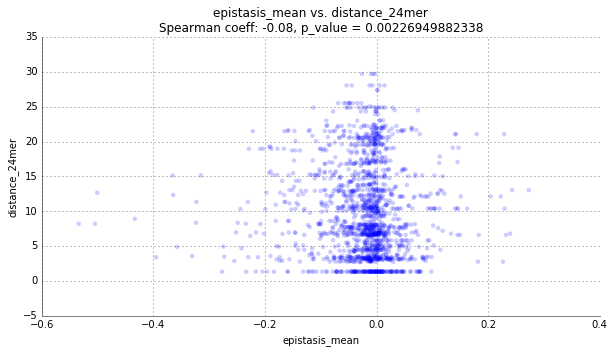

In [249]:
plot_better()
x = 'epistasis_mean'
y = 'distance_24mer'
title = '%s vs. %s' %(x,y)
statistics = stats.spearmanr(ep_summary.dropna()[x].values, ep_summary.dropna()[y].values)
print statistics
plt.scatter(ep_summary[x], ep_summary[y],
           edgecolor='none', alpha=0.2)
plt.title(title + '\nSpearman coeff: %.2f, p_value = %s' %(statistics[0], statistics[1]))
plt.xlabel(x)
plt.ylabel(y)

SpearmanrResult(correlation=-0.25495191588089083, pvalue=1.2001143720781609e-20)


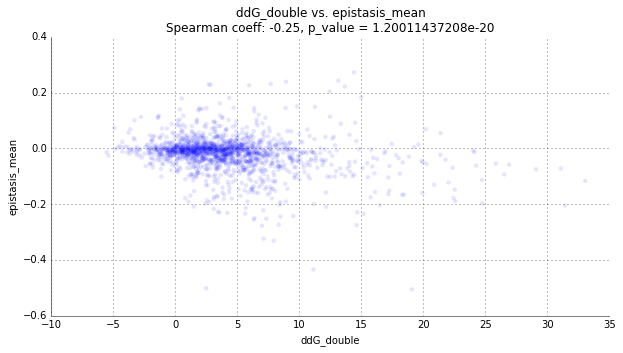

In [250]:
plot_better()
x = 'ddG_double'
y = 'epistasis_mean'
title = '%s vs. %s' %(x,y)
statistics = stats.spearmanr(ep_summary.dropna()[x].values, ep_summary.dropna()[y].values)
print statistics
plt.scatter(ep_summary[x], ep_summary[y],
           edgecolor='none', alpha=0.1)
plt.title(title + '\nSpearman coeff: %.2f, p_value = %s' %(statistics[0], statistics[1]))
plt.xlabel(x)
plt.ylabel(y)

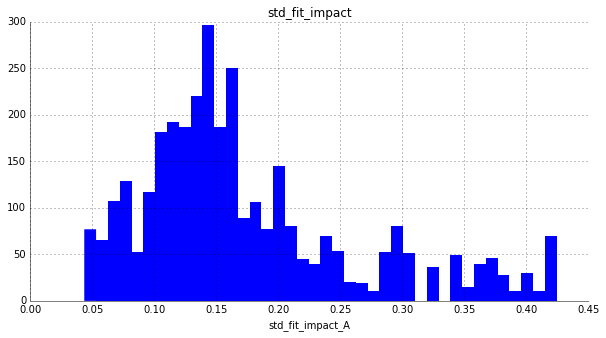

In [251]:
plot_better()
x = 'std_fit_impact_A'
y = 'std_fit_impact_B'

title = '%s' %(x[:-2])
plt.hist(list(ep_summary[x].values) + list(ep_summary[y].values), bins=40,
           edgecolor='none', alpha=1)
plt.title(title)
plt.xlabel(x)

SpearmanrResult(correlation=0.46755293945861154, pvalue=2.9468525486492813e-71)


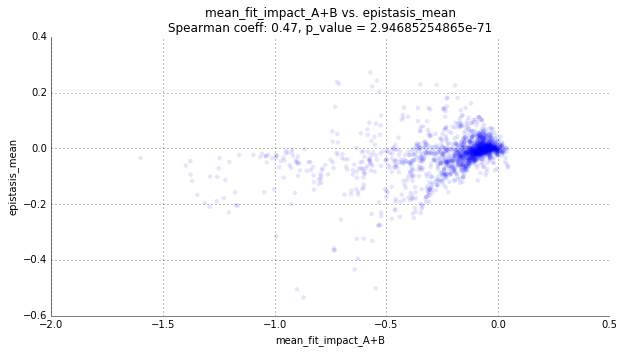

In [252]:
plot_better()
x = 'mean_fit_impact_A+B'
y = 'epistasis_mean'
title = '%s vs. %s' %(x,y)
statistics = stats.spearmanr(ep_summary.dropna()[x].values, ep_summary.dropna()[y].values)
print statistics
plt.scatter(ep_summary[x], ep_summary[y],
           edgecolor='none', alpha=0.1)
plt.title(title + '\nSpearman coeff: %.2f, p_value = %s' %(statistics[0], statistics[1]))
plt.xlabel(x)
plt.ylabel(y)

SpearmanrResult(correlation=-0.49183161863205599, pvalue=9.0634497427467234e-80)


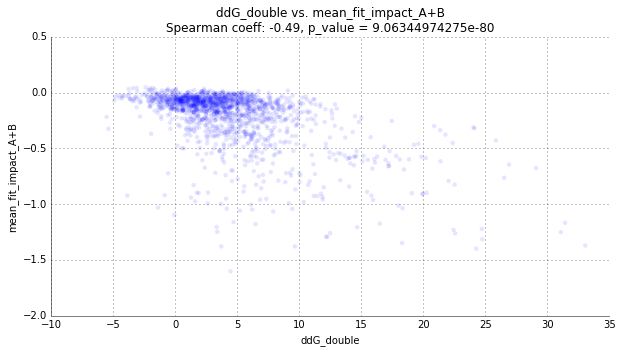

In [253]:
plot_better()
x = 'ddG_double'
y = 'mean_fit_impact_A+B'
title = '%s vs. %s' %(x,y)
statistics = stats.spearmanr(ep_summary.dropna()[x].values, ep_summary.dropna()[y].values)
print statistics
plt.scatter(ep_summary[x], ep_summary[y],
           edgecolor='none', alpha=0.1)
plt.title(title + '\nSpearman coeff: %.2f, p_value = %s' %(statistics[0], statistics[1]))
plt.xlabel(x)
plt.ylabel(y)

In [254]:
correlations = ep_summary[columns_for_correlation].corr(method='spearman')
for c in correlations.columns:
    correlations[c] = correlations[c].apply(lambda f: np.abs(f))

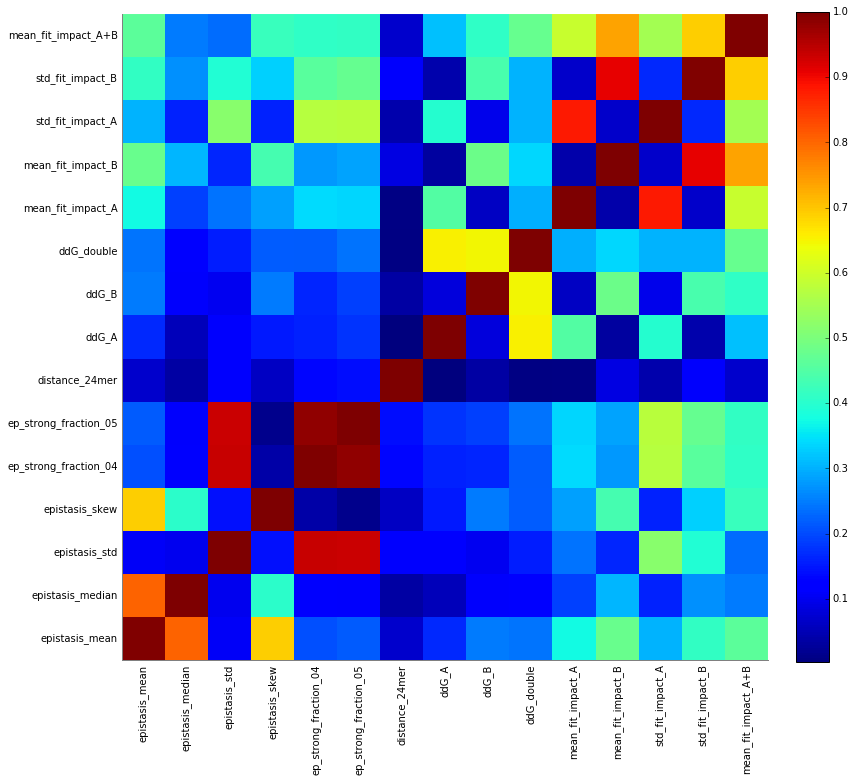

In [259]:
plot_better(width=12, height=12, grid='')
fig = plt.imshow(correlations, origin='lower', interpolation='none')
plt.colorbar(fig, fraction=0.046, pad=0.04)
plt.xticks(range(len(columns_for_correlation)), columns_for_correlation, rotation=90, ha='center');
plt.yticks(range(len(columns_for_correlation)), columns_for_correlation, rotation=0, va='center');
plt.tight_layout()
plt.savefig(figures_folder + 'summary_for_pairs_of_mutations.pdf')

In [256]:
ep_summary[ep_summary['ep_strong_fraction_05'] > 0.1]

,mutA,mutB,epistasis_mean,epistasis_median,epistasis_std,epistasis_skew,ep_strong_fraction_04,ep_strong_fraction_05,positionA,positionB,segment,distance_24mer,ddG_A,ddG_B,ddG_double,mean_fit_impact_A,mean_fit_impact_B,std_fit_impact_A,std_fit_impact_B,mean_fit_impact_A+B
32,104L,105Q,-0.184054,-0.059716,0.323342,-0.680462,0.230519,0.184343,104,105,S6,1.341683,NaN,NaN,NaN,-0.302321,-0.118158,0.362980,0.240751,-0.420479
36,104L,120A,0.054204,0.000805,0.291312,0.086778,0.151851,0.111746,104,120,S6,13.765706,NaN,4.499000,NaN,-0.302321,-0.006934,0.362980,0.131578,-0.309255
75,106D,115E,-0.185624,-0.121633,0.253495,-0.437612,0.221559,0.140449,106,115,S1,15.213204,1.265000,1.035000,2.541667,-0.083946,-0.310206,0.167103,0.358154,-0.394152
77,106D,131S,-0.192482,-0.145445,0.248665,-0.359413,0.207967,0.130885,106,131,S1,19.246679,1.265000,1.269333,2.727667,-0.083946,-0.237835,0.167103,0.297912,-0.321781
119,106N,115E,-0.178256,-0.111896,0.241641,-0.565162,0.203149,0.123804,106,115,S1,15.213204,-0.271000,1.035000,0.790667,-0.070693,-0.310206,0.147891,0.358154,-0.380899
121,106N,131S,-0.190371,-0.141872,0.236865,-0.543357,0.194491,0.115864,106,131,S1,19.246679,-0.271000,1.269333,1.048333,-0.070693,-0.237835,0.147891,0.297912,-0.308529
138,108I,115E,-0.156996,-0.091499,0.238072,-0.584588,0.177127,0.112553,108,115,S1,8.617396,5.762000,1.035000,5.849333,-0.058557,-0.310206,0.142328,0.358154,-0.368763
157,108M,115E,-0.180803,-0.115500,0.252881,-0.485033,0.207393,0.134118,108,115,S1,8.617396,1.889000,1.035000,3.111000,-0.074510,-0.310206,0.160129,0.358154,-0.384716
176,108V,115E,-0.159242,-0.095921,0.244213,-0.396261,0.185063,0.115477,108,115,S1,8.617396,7.904000,1.035000,7.604000,-0.081046,-0.310206,0.142143,0.358154,-0.391252
187,110D,115E,0.229455,0.174933,0.258283,0.325360,0.267097,0.183226,110,115,S1,10.393517,1.374000,1.035000,2.688000,-0.036875,-0.310206,0.109568,0.358154,-0.347080


In [257]:
ep_summary.to_hdf(files_dump_folder + 'Summary_for_pairs_of_mutations.hdf', 'data')
ep_summary.to_csv(files_dump_folder + 'Summary_for_pairs_of_mutations.csv', index=False)

In [288]:
colnames_His3_Scer_PLM = ['position1', 'amino_acid_1', 'position2', 'amino_acid_2', 'nothing', 'PML_score']
pd.read_table(files_dump_folder + 'evolutionary_coupling_analysis_with_evfold/ev_couplings/' + 'His3_Scer_PLM.txt',
             names=colnames_His3_Scer_PLM, sep=' ', header=None)[:4]

,position1,amino_acid_1,position2,amino_acid_2,nothing,PML_score
0,28,L,29,A,0,1.158260
1,28,L,30,I,0,0.810840
2,28,L,31,E,0,0.317860
3,28,L,32,H,0,0.313349


In [290]:
colnames_His3_Scer_CouplingScores = ['position1', 'position2', 'coupling_score', 'nothing', 'position1_conservation', 
'position2_conservation', 'secondary structure fiter (flag "999")', 'high conservation filter (flag "888")', 'something_else',
'cys-cys filter (flag "222")', 'amino_acid_1', 'amino_acid_2']
pd.read_csv(files_dump_folder + 'evolutionary_coupling_analysis_with_evfold/ev_couplings/' + 'His3_Scer_CouplingScores.csv', 
              names=colnames_His3_Scer_CouplingScores, header=None)

,position1,position2,coupling_score,nothing,position1_conservation,position2_conservation,"secondary structure fiter (flag ""999"")","high conservation filter (flag ""888"")",something_else,"cys-cys filter (flag ""222"")",amino_acid_1,amino_acid_2
0,44,31,1.55890,0,23,22,0,0,0,0,A,E
1,78,54,1.50510,0,26,25,0,0,0,0,I,N
2,167,104,1.43030,0,44,43,0,0,0,0,F,F
3,42,33,1.28060,0,14,27,0,0,0,0,A,S
4,183,161,1.25370,0,20,28,0,0,0,0,K,P
5,82,40,1.22560,0,33,29,0,0,0,0,I,A
6,70,53,1.20430,0,56,26,0,0,0,0,A,I
7,191,129,1.19450,0,49,44,0,0,0,0,S,S
8,195,131,1.17920,0,81,49,0,0,0,0,A,A
9,192,177,1.14180,0,20,37,0,0,0,0,A,V
